# Plot clade connectivity between timepoints

To ensure that clades are connected between timepoints, enabling model fitting across timepoints for all clades, plot the first timepoint each clade occurs in a network and connect adjacent clades with edges based on traversal of the tips-to-clades map for all timepoints.

In [33]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

plt.style.use("huddlej")

In [2]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [3]:
tips = pd.read_csv("../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/standardized_tip_attributes.tsv",
                   sep="\t", parse_dates=["timepoint"])
tips = tips.loc[
    tips["segment"] == "ha",
    ["strain", "clade_membership", "timepoint", "frequency"]
].copy()

In [4]:
valid_tips = tips.strain.unique()

In [5]:
valid_tips.shape

(1166,)

In [6]:
data_path = "../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/tips_to_clades.tsv"

In [7]:
df = pd.read_csv(data_path, sep="\t", parse_dates=["timepoint"])

In [8]:
df.shape

(136451, 6)

In [9]:
df.head()

,tip,clade_membership,depth,lineage,segment,timepoint
0,A/Indonesia/1142/2006,993737c,1,h3n2,ha,2009-10-01
1,A/Indonesia/1142/2006,root,2,h3n2,ha,2009-10-01
2,A/Leiden/87509/2005,ffaf2a6,1,h3n2,ha,2009-10-01
3,A/Leiden/87509/2005,993737c,2,h3n2,ha,2009-10-01
4,A/Leiden/87509/2005,root,3,h3n2,ha,2009-10-01


In [10]:
df["tip"].isin(valid_tips).sum()

105113

In [11]:
df = df[df["tip"].isin(valid_tips)].copy()

In [12]:
df = tips.merge(df, left_on="strain", right_on="tip", suffixes=["_tip", ""]).copy()

In [13]:
sorted_df = df.sort_values(["timepoint", "tip", "depth"]).copy()

In [14]:
sorted_df.head()

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint
0,A/Aichi/222/2009,ca7ba25,2009-10-01,0.004845,A/Aichi/222/2009,ca7ba25,1,h3n2,ha,2009-10-01
141,A/Aichi/222/2009,ca7ba25,2010-04-01,0.000089,A/Aichi/222/2009,ca7ba25,1,h3n2,ha,2009-10-01
1,A/Aichi/222/2009,ca7ba25,2009-10-01,0.004845,A/Aichi/222/2009,bbf33d0,2,h3n2,ha,2009-10-01
142,A/Aichi/222/2009,ca7ba25,2010-04-01,0.000089,A/Aichi/222/2009,bbf33d0,2,h3n2,ha,2009-10-01
2,A/Aichi/222/2009,ca7ba25,2009-10-01,0.004845,A/Aichi/222/2009,befedfa,3,h3n2,ha,2009-10-01


In [15]:
sorted_df["clade_membership"].unique().shape

(273,)

In [16]:
timepoint_by_clade_name = sorted_df.groupby("clade_membership")["timepoint_tip"].min().to_dict()
timepoint_by_clade_name["root"] = df["timepoint"].min() - pd.DateOffset(months=6)

In [17]:
clade_id_by_name = {"root": 20}
clade_counter_by_timepoint = defaultdict(int)

for clade, timepoint in timepoint_by_clade_name.items():
    clade_id_by_name[clade] = clade_counter_by_timepoint[timepoint]
    clade_counter_by_timepoint[timepoint] += 5

Create a graph that will connect all adjacent clades (essentially the original tree) and note the first timepoint each clade was observed.

In [18]:
tree = nx.Graph()

#timepoint_by_clade_name = {"root": df["timepoint"].min() - pd.DateOffset(months=6)}
observed_tips = set()

for timepoint, timepoint_df in sorted_df.groupby("timepoint"):
    print(timepoint)
    for tip, tip_df in timepoint_df.groupby("tip"):
        # Only consider the clade linkages for tips once when that tip is first observed.
        if tip in observed_tips:
            continue
        
        observed_tips.add(tip)
        clades = tip_df["clade_membership"].values
        
        # Loop through clades, adding edges between adjacent clades.
        for i in range(len(clades)):
            # Make sure each clade is represented in the tree.
            tree.add_node(clades[i])

            # Link each clade after the first one back to its relative.
            if i > 0:
                tree.add_edge(clades[i], clades[i - 1])

            # Note the first timepoint each clade was observed.
            #if clades[i] not in timepoint_by_clade_name:
            #    timepoint_by_clade_name[clades[i]] = tip_timepoint
            #    clade_id_by_name[clades[i]] = clade_counter_by_timepoint[tip_timepoint]
            #    clade_counter_by_timepoint[tip_timepoint] += 5

2009-10-01 00:00:00
2010-04-01 00:00:00
2010-10-01 00:00:00
2011-04-01 00:00:00
2011-10-01 00:00:00
2012-04-01 00:00:00
2012-10-01 00:00:00
2013-04-01 00:00:00
2013-10-01 00:00:00
2014-04-01 00:00:00
2014-10-01 00:00:00
2015-04-01 00:00:00
2015-10-01 00:00:00


In [19]:
tip_df["timepoint_tip"].drop_duplicates().iloc[0]

Timestamp('2015-04-01 00:00:00')

In [20]:
tip

'A/Zhejiang-Wuxin/130/2015'

In [21]:
tree["root"]

AtlasView({'eeb6263': {}, 'root': {}, 'cec9051': {}})

In [22]:
tip_df

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint
166052,A/Zhejiang-Wuxin/130/2015,4fcee9d,2015-04-01,0.035086,A/Zhejiang-Wuxin/130/2015,4fcee9d,1,h3n2,ha,2015-10-01
166080,A/Zhejiang-Wuxin/130/2015,4fcee9d,2015-10-01,0.000093,A/Zhejiang-Wuxin/130/2015,4fcee9d,1,h3n2,ha,2015-10-01
166053,A/Zhejiang-Wuxin/130/2015,4fcee9d,2015-04-01,0.035086,A/Zhejiang-Wuxin/130/2015,b4dc8e7,6,h3n2,ha,2015-10-01
166081,A/Zhejiang-Wuxin/130/2015,4fcee9d,2015-10-01,0.000093,A/Zhejiang-Wuxin/130/2015,b4dc8e7,6,h3n2,ha,2015-10-01
166054,A/Zhejiang-Wuxin/130/2015,4fcee9d,2015-04-01,0.035086,A/Zhejiang-Wuxin/130/2015,802f7eb,8,h3n2,ha,2015-10-01
166082,A/Zhejiang-Wuxin/130/2015,4fcee9d,2015-10-01,0.000093,A/Zhejiang-Wuxin/130/2015,802f7eb,8,h3n2,ha,2015-10-01
166055,A/Zhejiang-Wuxin/130/2015,4fcee9d,2015-04-01,0.035086,A/Zhejiang-Wuxin/130/2015,e846e03,9,h3n2,ha,2015-10-01
166083,A/Zhejiang-Wuxin/130/2015,4fcee9d,2015-10-01,0.000093,A/Zhejiang-Wuxin/130/2015,e846e03,9,h3n2,ha,2015-10-01
166056,A/Zhejiang-Wuxin/130/2015,4fcee9d,2015-04-01,0.035086,A/Zhejiang-Wuxin/130/2015,4159f3d,10,h3n2,ha,2015-10-01
166084,A/Zhejiang-Wuxin/130/2015,4fcee9d,2015-10-01,0.000093,A/Zhejiang-Wuxin/130/2015,4159f3d,10,h3n2,ha,2015-10-01


In [23]:
tree.number_of_nodes()

242

In [24]:
tree.number_of_edges()

451

In [25]:
positions = {clade: (timepoint_by_clade_name[clade].year + ((timepoint_by_clade_name[clade].month - 1) / 12.0), clade_id_by_name[clade])
             for clade in timepoint_by_clade_name}

In [26]:
list(positions.items())[:10]

[('00090db', (2014.25, 0)),
 ('00f8876', (2013.75, 0)),
 ('018eb9d', (2014.75, 0)),
 ('027b5bf', (2009.75, 0)),
 ('02fdebc', (2012.25, 0)),
 ('03cfee5', (2009.75, 5)),
 ('0455a76', (2010.75, 0)),
 ('04bf46f', (2009.75, 10)),
 ('0530f4a', (2011.75, 0)),
 ('056df9c', (2012.25, 5))]

In [27]:
edge_colors = []
for edge in tree.edges:
    delta = timepoint_by_clade_name[edge[1]] - timepoint_by_clade_name[edge[0]]
    if np.abs(delta.days) == 0:
        edge_colors.append("#ffffff")
    elif np.abs(delta.days) < 190:
        edge_colors.append("#cccccc")
    else:
        edge_colors.append("#000000")

In [28]:
valid_timepoints = sorted(set([position[0] for position in positions.values()]))

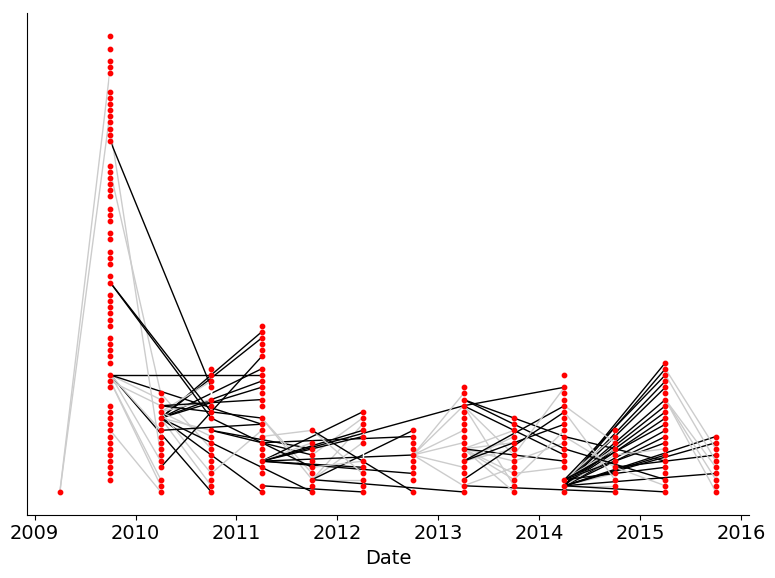

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

nx.draw(
    tree,
    pos=positions,
    ax=ax,
    node_size=10,
    edge_color=edge_colors,
    with_labels=False
)

ax.plot(valid_timepoints, [0.0] * len(valid_timepoints), alpha=0)
ax.set_xlabel("Date")
ax.set_yticks([])
plt.axis("on")
plt.tight_layout()

In [30]:
ax.set_yticks([])

[]

Look for nodes without any edges.

In [32]:
[node for node in tree if len(tree[node]) == 0]

[]

Look for nodes from the last timepoint that connect to nodes from more than one timepoint in the past.

In [33]:
recent_clades = [clade
                 for clade, timepoint in timepoint_by_clade_name.items()
                 if timepoint == df["timepoint"].max()]

In [34]:
recent_clades[:5]

[]

In [35]:
broken_clade = None
for recent_clade in recent_clades:
    for ancestor in tree[recent_clade]:
        delta = timepoint_by_clade_name[recent_clade] - timepoint_by_clade_name[ancestor]
        if delta.days > 190:
            print(delta)
            
        if delta.days > 370:
            print(recent_clade)
            broken_clade = recent_clade
            break
            
    if broken_clade is not None:
        break

In [36]:
recent_clade

NameError: name 'recent_clade' is not defined

In [36]:
broken_clade = "7d7cafb"

In [37]:
df[df["clade_membership"] == broken_clade].head()

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint


In [38]:
df[df["tip"] == "A/HongKong/4974/2011"].head()

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint
51148,A/HongKong/4974/2011,b4dc8e7,2011-04-01,0.033858,A/HongKong/4974/2011,b4dc8e7,1,h3n2,ha,2011-04-01
51149,A/HongKong/4974/2011,b4dc8e7,2011-04-01,0.033858,A/HongKong/4974/2011,c778e4c,3,h3n2,ha,2011-04-01
51150,A/HongKong/4974/2011,b4dc8e7,2011-04-01,0.033858,A/HongKong/4974/2011,4ac7eee,5,h3n2,ha,2011-04-01
51151,A/HongKong/4974/2011,b4dc8e7,2011-04-01,0.033858,A/HongKong/4974/2011,4f8826d,9,h3n2,ha,2011-04-01
51152,A/HongKong/4974/2011,b4dc8e7,2011-04-01,0.033858,A/HongKong/4974/2011,c8908a1,15,h3n2,ha,2011-04-01


In [39]:
tips[tips["strain"] == "A/Okayama/28/2011"]

,strain,clade_membership,timepoint,frequency


In [40]:
df[df["clade_membership"] == broken_clade].shape

(0, 10)

In [41]:
bahia_df = df[(df["tip"] == "A/Bahia/100/2011") & (df["timepoint"] == "2012-04-01")]

In [43]:
bahia_df.head()

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint
47487,A/Bahia/100/2011,de216e4,2011-04-01,0.003108,A/Bahia/100/2011,ed755a8,1,h3n2,ha,2012-04-01
47488,A/Bahia/100/2011,de216e4,2011-04-01,0.003108,A/Bahia/100/2011,aaf9241,4,h3n2,ha,2012-04-01
47489,A/Bahia/100/2011,de216e4,2011-04-01,0.003108,A/Bahia/100/2011,e759c92,19,h3n2,ha,2012-04-01
47490,A/Bahia/100/2011,de216e4,2011-04-01,0.003108,A/Bahia/100/2011,7db2310,21,h3n2,ha,2012-04-01
47491,A/Bahia/100/2011,de216e4,2011-04-01,0.003108,A/Bahia/100/2011,4829098,22,h3n2,ha,2012-04-01


In [44]:
parana_df = df[(df["tip"] == "A/Parana/415/2012") & (df["timepoint"] == "2012-10-01")]

In [45]:
parana_df

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint


In [46]:
tips[tips["strain"] == "A/Bahia/100/2011"]

,strain,clade_membership,timepoint,frequency
348,A/Bahia/100/2011,de216e4,2011-04-01,0.003108
483,A/Bahia/100/2011,ed755a8,2011-10-01,0.002033


In [47]:
tips[tips["strain"] == "A/HoChiMinh/6388/2010"]

,strain,clade_membership,timepoint,frequency


In [48]:
# Identify distinct clades per timepoint.
clades = tips.loc[:, ["timepoint", "clade_membership"]].drop_duplicates().copy()
clades = clades.rename(columns={"timepoint": "initial_timepoint"})

In [49]:
clades[clades["clade_membership"] == "93a23e6"]

,initial_timepoint,clade_membership


In [50]:
df[df["clade_membership"] == "93a23e6"]

,strain,clade_membership_tip,timepoint_tip,frequency,tip,clade_membership,depth,lineage,segment,timepoint


In [52]:
clades[clades["initial_timepoint"] == "2012-04-01"].head()

,initial_timepoint,clade_membership
618,2012-04-01,1de1231
619,2012-04-01,b4dc8e7
621,2012-04-01,4fcee9d
623,2012-04-01,ec55f9a
624,2012-04-01,514e67b


In [53]:
clades[clades["initial_timepoint"] == "2012-10-01"].head()

,initial_timepoint,clade_membership
763,2012-10-01,d109669
764,2012-10-01,1de1231
765,2012-10-01,4fcee9d
766,2012-10-01,6625e83
771,2012-10-01,ee6085f


In [54]:
final_clade_frequencies = pd.read_table("../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/final_clade_frequencies.tsv")

In [55]:
final_clade_frequencies.groupby(["initial_timepoint", "clade_membership"])["frequency"].sum()

initial_timepoint  clade_membership
2009-10-01         0818a58             0.000000
                   10b53cd             0.000000
                   155c578             0.000000
                   1c3e334             0.000000
                   3981529             0.000000
                   4692cef             0.004511
                   4f8826d             0.837302
                   5a43b5f             0.000000
                   5ea83cf             0.000554
                   68a154d             0.000000
                   6907cdf             0.000000
                   76d3967             0.000000
                   77e0838             0.000000
                   816a19e             0.000000
                   8c6e6c2             0.000000
                   8c9c2a3             0.000000
                   9213179             0.004940
                   9ea093f             0.000000
                   a1211fc             0.000000
                   a54d1ad             0.000000
    

In [56]:
clade_counts = final_clade_frequencies.groupby(["initial_timepoint", "clade_membership"])["frequency"].sum().reset_index()

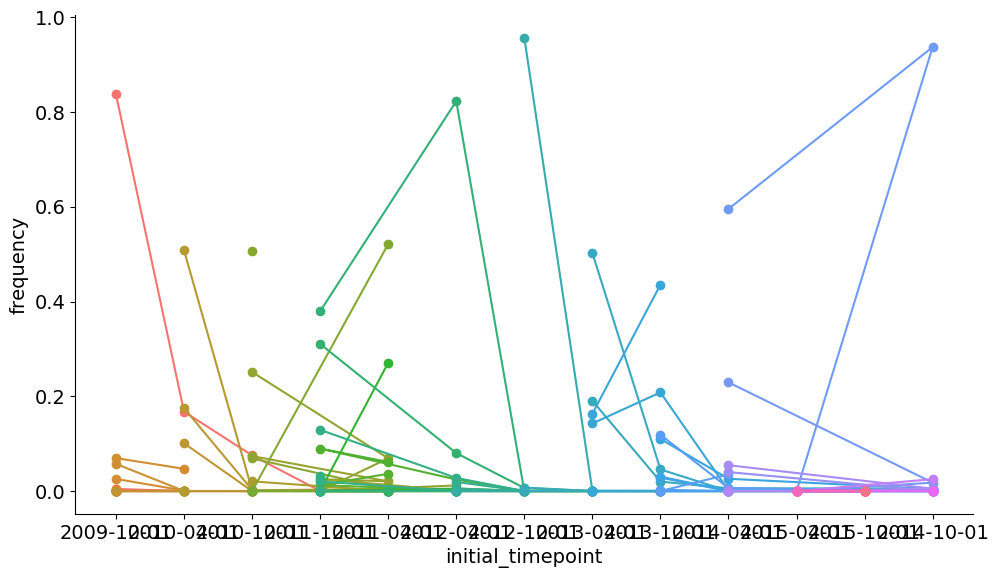

In [57]:
g = sns.FacetGrid(clade_counts, hue="clade_membership", height=6, aspect=1.7)
g.map(plt.plot, "initial_timepoint", "frequency", marker="o")
#g.axes.flatten()[0].set_ylim(0, 1)

## Reattempt clade connectivity plots

Build the table of future tips by clade for all distinct clades by timepoint, plot those clades by timepoint, and then plot connections between clades at timepoints where future tip frequencies are non-zero.

In [247]:
delta_months = 12
primary_segment = "ha"
delta_time_offset = pd.DateOffset(months=delta_months)

In [248]:
tips = pd.read_csv("../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/standardized_tip_attributes.tsv",
                   sep="\t", parse_dates=["timepoint"])
tips = tips.loc[
    tips["segment"] == "ha",
    ["strain", "clade_membership", "timepoint", "frequency"]
].copy()

In [249]:
tips.head()

,strain,clade_membership,timepoint,frequency
0,A/Aichi/222/2009,ca7ba25,2009-10-01,0.004845
1,A/Algeria/G202/2009,fd5868f,2009-10-01,0.000015
2,A/Argentina/7646/2009,5ea83cf,2009-10-01,0.006527
3,A/Astrakhan/7/2009,5ea83cf,2009-10-01,0.009280
4,A/Australia/30/2009,4f8826d,2009-10-01,0.000535


In [250]:
tips.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index().sort_values(["timepoint", "frequency"])

,timepoint,clade_membership,frequency
14,2009-10-01,8c6e6c2,0.000001
13,2009-10-01,816a19e,0.000002
1,2009-10-01,10b53cd,0.000004
15,2009-10-01,8c9c2a3,0.000013
3,2009-10-01,1c3e334,0.000072
19,2009-10-01,a54d1ad,0.000347
32,2009-10-01,f7571c1,0.000469
7,2009-10-01,5a43b5f,0.000622
17,2009-10-01,9ea093f,0.000848
4,2009-10-01,3981529,0.001647


In [251]:
# Identify distinct clades per timepoint.
clades = tips.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index().sort_values(["timepoint", "frequency"]).copy()
clades = clades.rename(columns={"timepoint": "initial_timepoint"})
clades = clades.drop(columns="frequency")

In [252]:
# Annotate future timepoint.
clades["final_timepoint"] = clades["initial_timepoint"] + delta_time_offset

In [253]:
clades.head()

,initial_timepoint,clade_membership,final_timepoint
14,2009-10-01,8c6e6c2,2010-10-01
13,2009-10-01,816a19e,2010-10-01
1,2009-10-01,10b53cd,2010-10-01
15,2009-10-01,8c9c2a3,2010-10-01
3,2009-10-01,1c3e334,2010-10-01


In [254]:
for timepoint, timepoint_df in clades.groupby("initial_timepoint"):
    clades.loc[clades["initial_timepoint"] == timepoint, "y"] = np.arange(len(timepoint_df))

In [255]:
clades.head(20)

,initial_timepoint,clade_membership,final_timepoint,y
14,2009-10-01,8c6e6c2,2010-10-01,0.0
13,2009-10-01,816a19e,2010-10-01,1.0
1,2009-10-01,10b53cd,2010-10-01,2.0
15,2009-10-01,8c9c2a3,2010-10-01,3.0
3,2009-10-01,1c3e334,2010-10-01,4.0
19,2009-10-01,a54d1ad,2010-10-01,5.0
32,2009-10-01,f7571c1,2010-10-01,6.0
7,2009-10-01,5a43b5f,2010-10-01,7.0
17,2009-10-01,9ea093f,2010-10-01,8.0
4,2009-10-01,3981529,2010-10-01,9.0


In [256]:
# Load mapping of tips to all possible clades at each timepoint.
tips_to_clades = pd.read_csv("../results/builds/h3n2/5_viruses_per_month/sample_0/2005-10-01--2015-10-01/tips_to_clades.tsv", sep="\t", parse_dates=["timepoint"])
tips_to_clades = tips_to_clades.loc[
    tips_to_clades["segment"] == primary_segment,
    ["tip", "clade_membership", "depth", "timepoint"]
].copy()

In [257]:
# Get all tip-clade combinations by timepoint for the distinct clades.
future_tips_by_clades = clades.merge(
    tips_to_clades,
    how="inner",
    left_on=["final_timepoint", "clade_membership"],
    right_on=["timepoint", "clade_membership"]
)

In [258]:
# Drop redundant columns.
future_tips_by_clades = future_tips_by_clades.drop(
    columns=["timepoint"]
)

In [259]:
future_tips_by_clades.head()

,initial_timepoint,clade_membership,final_timepoint,y,tip,depth
0,2009-10-01,8c6e6c2,2010-10-01,0.0,A/California/8/2008,1
1,2009-10-01,8c6e6c2,2010-10-01,0.0,A/Kyrgyzstan/WRAIR1256P/2008,1
2,2009-10-01,8c6e6c2,2010-10-01,0.0,A/Brazil/1814/2009,2
3,2009-10-01,8c6e6c2,2010-10-01,0.0,A/Brazil/884/2009,2
4,2009-10-01,816a19e,2010-10-01,1.0,A/Malaysia/1779027/2007,1


In [260]:
# Get the closest clade to each tip by timepoint. This relies on records
# being sorted by depth of clade from tip.
future_tips_by_clades = future_tips_by_clades.sort_values(["initial_timepoint", "tip", "depth"]).groupby(["initial_timepoint"\
, "tip"]).first().reset_index()

In [261]:
future_tips_by_clades.head()

,initial_timepoint,tip,clade_membership,final_timepoint,y,depth
0,2009-10-01,A/Acre/15093/2010,befedfa,2010-10-01,24.0,3
1,2009-10-01,A/Acre/26954/2010,befedfa,2010-10-01,24.0,3
2,2009-10-01,A/Afghanistan/2950/2009,4f8826d,2010-10-01,32.0,1
3,2009-10-01,A/Afghanistan/AF1173/2008,5ea83cf,2010-10-01,31.0,1
4,2009-10-01,A/Aichi/114/2008,5ea83cf,2010-10-01,31.0,5


In [262]:
future_tips_by_clades[future_tips_by_clades["tip"] == "A/Aichi/114/2008"]

,initial_timepoint,tip,clade_membership,final_timepoint,y,depth
4,2009-10-01,A/Aichi/114/2008,5ea83cf,2010-10-01,31.0,5
346,2010-04-01,A/Aichi/114/2008,5ea83cf,2011-04-01,11.0,5


In [263]:
# Get frequencies of future tips associated with current clades.
future_clade_frequencies = future_tips_by_clades.merge(tips, how="inner", left_on=["tip", "final_timepoint"], right_on=["strain", "timepoint"], suffixes=["", "_tip"])
future_clade_frequencies = future_clade_frequencies.drop(
    columns=[
        "tip",
        "depth",
        "clade_membership_tip",
        "timepoint"
    ]
)

In [264]:
future_clade_frequencies.head()

,initial_timepoint,clade_membership,final_timepoint,y,strain,frequency
0,2009-10-01,befedfa,2010-10-01,24.0,A/Acre/15093/2010,0.000980
1,2009-10-01,befedfa,2010-10-01,24.0,A/Acre/26954/2010,0.003129
2,2009-10-01,4f8826d,2010-10-01,32.0,A/Afghanistan/2950/2009,0.000001
3,2009-10-01,c86656c,2010-10-01,28.0,A/Akita/7/2010,0.004861
4,2009-10-01,4f8826d,2010-10-01,32.0,A/Alabama/5/2010,0.014053


In [265]:
future_clade_frequencies.groupby("initial_timepoint")["frequency"].sum()

initial_timepoint
2009-10-01    0.999999
2010-04-01    1.000004
2010-10-01    0.999994
2011-04-01    0.999997
2011-10-01    0.999995
2012-04-01    1.000009
2012-10-01    0.970947
2013-04-01    1.000002
2013-10-01    1.000005
2014-04-01    0.999998
2014-10-01    0.996246
Name: frequency, dtype: float64

(0.9, 1.02)

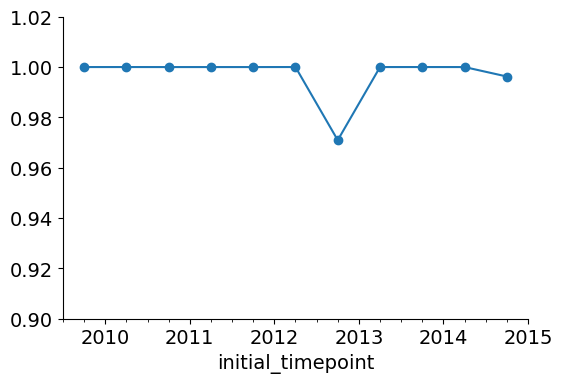

In [288]:
ax = future_clade_frequencies.groupby("initial_timepoint")["frequency"].sum().plot(marker="o")
ax.set_ylim(0.9, 1.02)

In [266]:
future_clades = future_clade_frequencies.loc[:, ["initial_timepoint", "final_timepoint", "clade_membership"]].drop_duplicates()

In [267]:
clades.shape

(425, 4)

In [268]:
clades.head()

,initial_timepoint,clade_membership,final_timepoint,y
14,2009-10-01,8c6e6c2,2010-10-01,0.0
13,2009-10-01,816a19e,2010-10-01,1.0
1,2009-10-01,10b53cd,2010-10-01,2.0
15,2009-10-01,8c9c2a3,2010-10-01,3.0
3,2009-10-01,1c3e334,2010-10-01,4.0


In [269]:
future_clades.shape

(102, 3)

In [270]:
future_clades["color"] = "#999999"

In [271]:
future_clades.head()

,initial_timepoint,final_timepoint,clade_membership,color
0,2009-10-01,2010-10-01,befedfa,#999999
2,2009-10-01,2010-10-01,4f8826d,#999999
3,2009-10-01,2010-10-01,c86656c,#999999
11,2009-10-01,2010-10-01,bbf33d0,#999999
27,2009-10-01,2010-10-01,ca15bc8,#999999


In [272]:
clades.head()

,initial_timepoint,clade_membership,final_timepoint,y
14,2009-10-01,8c6e6c2,2010-10-01,0.0
13,2009-10-01,816a19e,2010-10-01,1.0
1,2009-10-01,10b53cd,2010-10-01,2.0
15,2009-10-01,8c9c2a3,2010-10-01,3.0
3,2009-10-01,1c3e334,2010-10-01,4.0


In [273]:
clades.shape

(425, 4)

In [274]:
clades_with_future_clades = clades.merge(future_clades, how="left", on=["initial_timepoint", "final_timepoint", "clade_membership"])

In [275]:
clades_with_future_clades.loc[pd.isnull(clades_with_future_clades["color"]), "color"] = "#cccccc"

In [276]:
clades_with_future_clades.head()

,initial_timepoint,clade_membership,final_timepoint,y,color
0,2009-10-01,8c6e6c2,2010-10-01,0.0,#cccccc
1,2009-10-01,816a19e,2010-10-01,1.0,#cccccc
2,2009-10-01,10b53cd,2010-10-01,2.0,#cccccc
3,2009-10-01,8c9c2a3,2010-10-01,3.0,#cccccc
4,2009-10-01,1c3e334,2010-10-01,4.0,#cccccc


In [277]:
tips[tips["clade_membership"] == "8c6e6c2"]

,strain,clade_membership,timepoint,frequency
48,A/Kyrgyzstan/WRAIR1256P/2008,8c6e6c2,2009-10-01,0.000001


In [278]:
clades_with_future_clades[clades_with_future_clades["color"] == "#cccccc"].shape

(323, 5)

In [279]:
clades_with_future_clades[clades_with_future_clades["color"] == "#cccccc"].merge(tips, left_on=["initial_timepoint", "clade_membership"],
                                                                                 right_on=["timepoint", "clade_membership"]).groupby(
    ["initial_timepoint", "clade_membership"]
)["frequency"].count()

initial_timepoint  clade_membership
2009-10-01         0818a58              2
                   10b53cd              1
                   155c578              3
                   1c3e334              2
                   3981529              2
                   5a43b5f              2
                   68a154d              1
                   6907cdf              2
                   76d3967              2
                   77e0838              4
                   816a19e              1
                   8c6e6c2              1
                   8c9c2a3              1
                   9ea093f              2
                   a1211fc              4
                   a54d1ad              5
                   a68c89f              2
                   ab0001b              2
                   b70fa09              1
                   babdd52              3
                   ca7ba25              2
                   cbb5fb5              2
                   d0f14f6              

In [280]:
tips[tips["clade_membership"] == "a54d1ad"]

,strain,clade_membership,timepoint,frequency
44,A/Kuwait/WRAIR1143P/2009,a54d1ad,2009-10-01,0.000163
46,A/Kyrgyzstan/WRAIR1121P/2008,a54d1ad,2009-10-01,0.000002
47,A/Kyrgyzstan/WRAIR1255P/2008,a54d1ad,2009-10-01,0.000001
72,A/Moscow/402/2009,a54d1ad,2009-10-01,0.000163
92,A/Qazvin/9/2009,a54d1ad,2009-10-01,0.000018


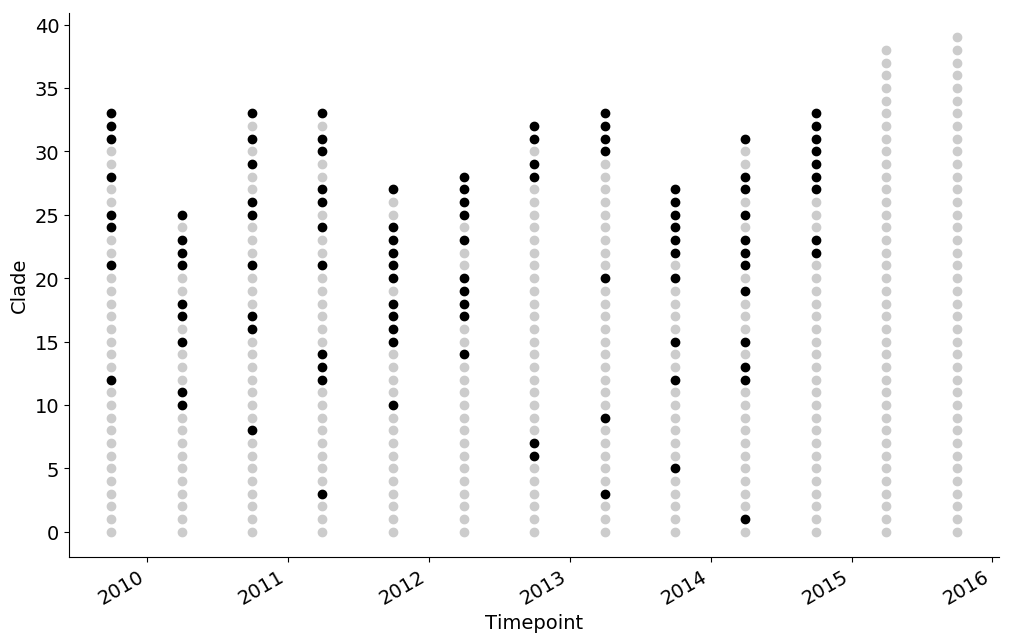

In [281]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

present = clades_with_future_clades[clades_with_future_clades["color"] == "#999999"]
ax.plot(present["initial_timepoint"], present["y"], "o", linestyle="", c="#000000")

absent = clades_with_future_clades[clades_with_future_clades["color"] == "#cccccc"]
ax.plot(absent["initial_timepoint"], absent["y"], "o", linestyle="", c="#cccccc")

ax.set_xlabel("Timepoint")
ax.set_ylabel("Clade")
plt.gcf().autofmt_xdate()